In [51]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline



In [52]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Loan Default Prediction") \
    .getOrCreate()

In [53]:
# Load data



train_df = spark.read.csv("Training Data.csv", header=True, inferSchema=True)
train_df.show()

+---+-------+---+----------+--------------+---------------+-------------+--------------------+-------------------+--------------+---------------+-----------------+---------+
| Id| Income|Age|Experience|Married/Single|House_Ownership|Car_Ownership|          Profession|               CITY|         STATE|CURRENT_JOB_YRS|CURRENT_HOUSE_YRS|Risk_Flag|
+---+-------+---+----------+--------------+---------------+-------------+--------------------+-------------------+--------------+---------------+-----------------+---------+
|  1|1303834| 23|         3|        single|         rented|           no| Mechanical_engineer|               Rewa|Madhya_Pradesh|              3|               13|        0|
|  2|7574516| 40|        10|        single|         rented|           no|  Software_Developer|           Parbhani|   Maharashtra|              9|               13|        0|
|  3|3991815| 66|         4|       married|         rented|           no|    Technical_writer|          Alappuzha|        Kerala| 

In [54]:
# EDA
train_df.describe().show()
train_df.printSchema()

+-------+-----------------+-----------------+------------------+------------------+--------------+---------------+-------------+--------------------+-----------+--------------+------------------+------------------+------------------+
|summary|               Id|           Income|               Age|        Experience|Married/Single|House_Ownership|Car_Ownership|          Profession|       CITY|         STATE|   CURRENT_JOB_YRS| CURRENT_HOUSE_YRS|         Risk_Flag|
+-------+-----------------+-----------------+------------------+------------------+--------------+---------------+-------------+--------------------+-----------+--------------+------------------+------------------+------------------+
|  count|           252000|           252000|            252000|            252000|        252000|         252000|       252000|              252000|     252000|        252000|            252000|            252000|            252000|
|   mean|         126000.5|4997116.665325397| 49.95407142857143|

In [55]:
train_df.dtypes

[('Id', 'int'),
 ('Income', 'int'),
 ('Age', 'int'),
 ('Experience', 'int'),
 ('Married/Single', 'string'),
 ('House_Ownership', 'string'),
 ('Car_Ownership', 'string'),
 ('Profession', 'string'),
 ('CITY', 'string'),
 ('STATE', 'string'),
 ('CURRENT_JOB_YRS', 'int'),
 ('CURRENT_HOUSE_YRS', 'int'),
 ('Risk_Flag', 'int')]

In [56]:
train_df = train_df.drop('id')

In [57]:
# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = train_df.randomSplit([0.8, 0.2], seed=1234)


In [58]:
categorical_cols = [col for col,type in train_df.dtypes if type=='string']
numerical_cols = [col for col,type in train_df.dtypes if type=='int' and col !='Risk_Flag']

print(categorical_cols)
print(numerical_cols)


['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']
['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']


In [59]:

indexers = []
encoders = []
encoded_feature_cols = []

# Create indexers and encoders for each categorical feature
for feature in categorical_cols:
    indexer = StringIndexer(inputCol=feature, outputCol=f"{feature}_index")
    encoder = OneHotEncoder(inputCol=f"{feature}_index", outputCol=f"{feature}_ohe")
    indexers.append(indexer)
    encoders.append(encoder)
    encoded_feature_cols.append(f"{feature}_ohe")
encoded_feature_cols

['Married/Single_ohe',
 'House_Ownership_ohe',
 'Car_Ownership_ohe',
 'Profession_ohe',
 'CITY_ohe',
 'STATE_ohe']

In [60]:
encoded_feature_cols.extend(numerical_cols)
encoded_feature_cols

['Married/Single_ohe',
 'House_Ownership_ohe',
 'Car_Ownership_ohe',
 'Profession_ohe',
 'CITY_ohe',
 'STATE_ohe',
 'Income',
 'Age',
 'Experience',
 'CURRENT_JOB_YRS',
 'CURRENT_HOUSE_YRS']

In [61]:

# Create a combined feature vector
assembler = VectorAssembler(inputCols=encoded_feature_cols, outputCol="features")

# scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")


In [62]:
#define different models
lr = LogisticRegression(featuresCol='features', labelCol='Risk_Flag',rawPredictionCol='rawPrediction')
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Risk_Flag', rawPredictionCol='rawPrediction')
rf = RandomForestClassifier(featuresCol='features', labelCol='Risk_Flag', rawPredictionCol='rawPrediction')
gb = GBTClassifier(featuresCol='features', labelCol='Risk_Flag')

models = [lr, dt, rf,gb]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest','Gradient boost']


In [63]:
evaluator = BinaryClassificationEvaluator(labelCol='Risk_Flag', rawPredictionCol='rawPrediction', metricName='areaUnderROC')


In [64]:
def get_best_model(models,model_names,train_data,test_data):
    
    best_model = None
    best_model_name = None
    best_roc_auc = 0.0
    
    for model, model_name in zip(models, model_names):
        # Create a pipeline with the indexers, encoders, assembler, and model
        pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, model])
        
        # Fit the pipeline model on the training data
        pipeline_model = pipeline.fit(train_data)
        
        # Make predictions on the test data
        predictions = pipeline_model.transform(test_data)
        
        # Evaluate the model
        roc_auc = evaluator.evaluate(predictions)
        print(f"ROC-AUC for {model_name}: {roc_auc}")
        
        # Update the best model if the current model's ROC-AUC is higher
        if roc_auc > best_roc_auc:
            best_model = pipeline_model
            best_model_name = model_name
            best_roc_auc = roc_auc
    
    print(f"Best Model: {best_model_name} with ROC-AUC: {best_roc_auc}")

    return best_model,best_model_name

In [65]:
best_model,best_model_name = get_best_model(models,model_names,train_data,test_data)
best_predictions = best_model.transform(test_data)
best_predictions.show()

ROC-AUC for Logistic Regression: 0.6247875070448479
ROC-AUC for Decision Tree: 0.475568605520929
ROC-AUC for Random Forest: 0.5735926131714886
ROC-AUC for Gradient boost: 0.6361315823692165
Best Model: Gradient boost with ROC-AUC: 0.6361315823692165
+------+---+----------+--------------+---------------+-------------+-------------+---------------+--------------+---------------+-----------------+---------+--------------------+---------------------+-------------------+----------------+----------+-----------+------------------+-------------------+-----------------+---------------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+----------+
|Income|Age|Experience|Married/Single|House_Ownership|Car_Ownership|   Profession|           CITY|         STATE|CURRENT_JOB_YRS|CURRENT_HOUSE_YRS|Risk_Flag|Married/Single_index|House_Ownership_index|Car_Ownership_index|Profession_index|CITY_index|STATE_index|Married/Single_ohe|House_Ow

In [66]:
#best_predictions.toPandas().to_csv("prediction2.csv")
best_predictions.toPandas().to_csv("prediction3.csv")

Exception ignored in: <function JavaModelWrapper.__del__ at 0x000001E71E3FFE20>
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\Lib\site-packages\pyspark\mllib\common.py", line 152, in __del__
    assert self._sc._gateway is not None
           ^^^^^^^^
AttributeError: 'MulticlassMetrics' object has no attribute '_sc'
Exception ignored in: <function JavaWrapper.__del__ at 0x000001E7126945E0>
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\Lib\site-packages\pyspark\ml\wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'GBTClassifier' object has no attribute '_java_obj'


In [67]:
def get_feature_importance(best_model,best_model_name):
    # Get feature importances if the best model is DecisionTree or RandomForest or Gradient boost
    if best_model_name in ['Decision Tree', 'Random Forest','Gradient boost','Decision Tree']:
        # Extract the actual classifier model from the pipeline
        classifier_model = best_model.stages[-1]
        importances = classifier_model.featureImportances
        feature_importance = [(name, importance) for name, importance in zip(encoded_feature_cols, importances)]
        feature_importance.sort(key=lambda x: x[1], reverse=True)  # Sort by importance
        print(f"Feature importances for {best_model_name}:")
        for feature, importance in feature_importance:
            print(f"{feature}: {importance}")

    elif best_model_name == 'Logistic Regression':
        # For Logistic Regression, use the coefficients as feature importance
        classifier_model = best_model.stages[-1]
        coefficients = classifier_model.coefficients
        feature_importance = [(name, abs(coef)) for name, coef in zip(encoded_feature_cols, coefficients)]
        feature_importance.sort(key=lambda x: x[1], reverse=True)  # Sort by absolute coefficient value
        print(f"Feature importances for {best_model_name}:")
        for feature, importance in feature_importance:
            print(f"{feature}: {importance}")

In [68]:
get_feature_importance(best_model,best_model_name)
# show the table for feature importance

Feature importances for Gradient boost:
Profession_ohe: 0.020603014931877908
Married/Single_ohe: 0.015490987861642111
House_Ownership_ohe: 0.005543916094293392
Income: 0.004634620382842493
CITY_ohe: 0.0026565734089726237
CURRENT_HOUSE_YRS: 0.0019428293451339298
STATE_ohe: 0.0005087578108671643
Age: 0.00040304803201410126
CURRENT_JOB_YRS: 0.00028704957172324985
Car_Ownership_ohe: 9.407238959224e-05
Experience: 0.0


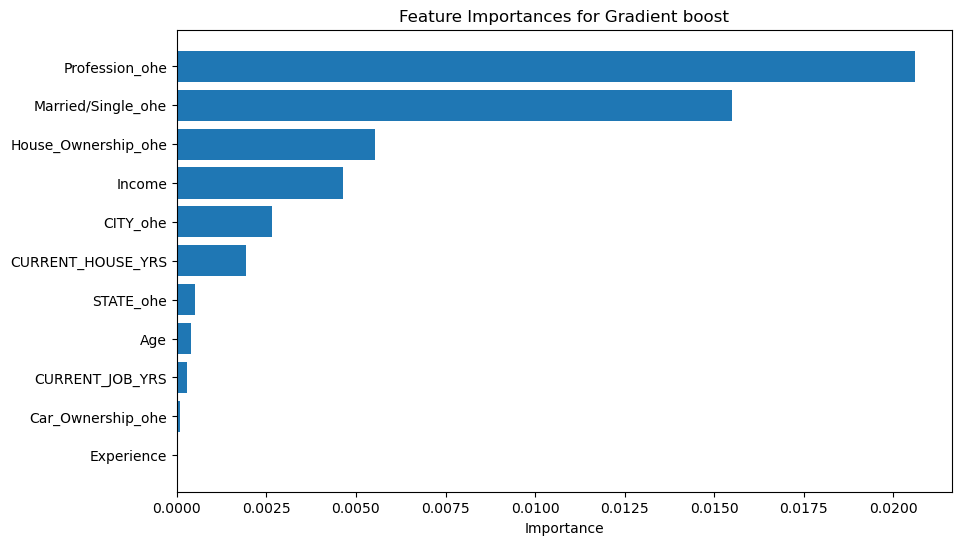

In [77]:
import matplotlib.pyplot as plt

def plot_feature_importance(feature_importance, model_name):
    features, importances = zip(*feature_importance)
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances, align='center')
    plt.xlabel('Importance')
    plt.title(f'Feature Importances for {model_name}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()

# Assuming `feature_importance` is the list of tuples [(feature_name, importance)]
feature_importance = [('Profession_ohe', 0.020603014931877908),
                      ('Married/Single_ohe', 0.015490987861642111),
                      ('House_Ownership_ohe', 0.005543916094293392),
                      ('Income', 0.004634620382842493),
                      ('CITY_ohe', 0.0026565734089726237),
                      ('CURRENT_HOUSE_YRS', 0.0019428293451339298),
                      ('STATE_ohe', 0.0005087578108671643),
                      ('Age', 0.00040304803201410126),
                      ('CURRENT_JOB_YRS', 0.00028704957172324985),
                      ('Car_Ownership_ohe', 9.407238959224e-05),
                      ('Experience', 0.0)]

plot_feature_importance(feature_importance, best_model_name)


In [70]:
best_model,best_model_name = get_best_model(models,model_names,train_data,test_data)
best_predictions = best_model.transform(test_data)
best_predictions.show()

ROC-AUC for Logistic Regression: 0.6247809053219694
ROC-AUC for Decision Tree: 0.475568605520929
ROC-AUC for Random Forest: 0.5735926131714886
ROC-AUC for Gradient boost: 0.6361544883470829
Best Model: Gradient boost with ROC-AUC: 0.6361544883470829
+------+---+----------+--------------+---------------+-------------+-------------+---------------+--------------+---------------+-----------------+---------+--------------------+---------------------+-------------------+----------------+----------+-----------+------------------+-------------------+-----------------+---------------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+----------+
|Income|Age|Experience|Married/Single|House_Ownership|Car_Ownership|   Profession|           CITY|         STATE|CURRENT_JOB_YRS|CURRENT_HOUSE_YRS|Risk_Flag|Married/Single_index|House_Ownership_index|Car_Ownership_index|Profession_index|CITY_index|STATE_index|Married/Single_ohe|House_Ow

   Unnamed: 0  Income  Age  Experience Married/Single House_Ownership  \
0           0   10310   70          20         single          rented   
1           1   10310   70          20         single          rented   
2           2   11114   73          19         single          rented   
3           3   11430   70          20         single          rented   
4           4   11430   70          20         single          rented   

  Car_Ownership     Profession             CITY           STATE  ...  \
0           yes       Engineer        Baranagar     West_Bengal  ...   
1           yes       Engineer        Baranagar     West_Bengal  ...   
2            no       Surveyor  Nellore[14][15]  Andhra_Pradesh  ...   
3           yes  Civil_servant  Kalyan-Dombivli     Maharashtra  ...   
4           yes  Civil_servant  Kalyan-Dombivli     Maharashtra  ...   

   House_Ownership_ohe  Car_Ownership_ohe   Profession_ohe           CITY_ohe  \
0        (2,[0],[1.0])          (1,[],[])      

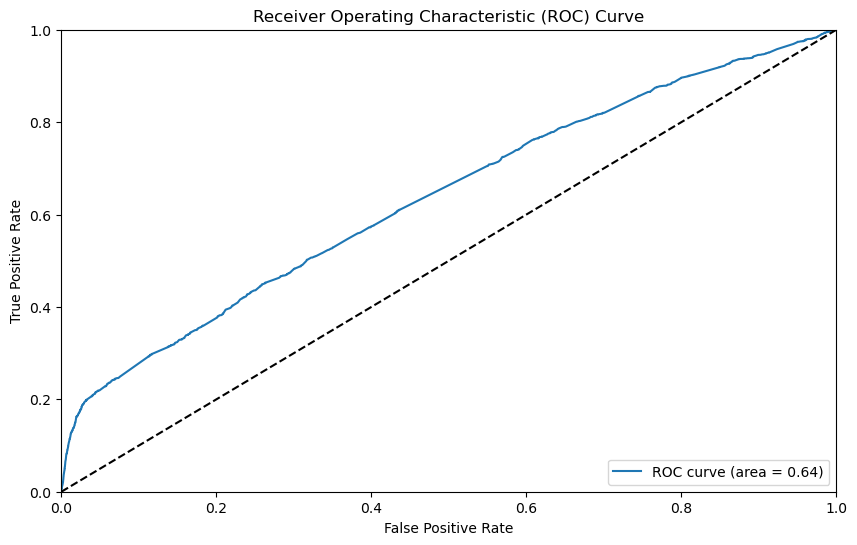

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Load the CSV file
df = pd.read_csv('prediction3.csv')

# Inspect the first few rows of the dataframe to check the column names and data types
print(df.head())
print(df.dtypes)

# Convert columns to the correct data types if necessary
# Assuming the predicted probabilities and true labels are in the 'probability' and 'Risk_Flag' columns

# Extract the probability of the positive class from the 'probability' column
df['probability'] = df['probability'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else x)

# Convert 'Risk_Flag' to numeric
df['Risk_Flag'] = pd.to_numeric(df['Risk_Flag'], errors='coerce')

# Drop rows with NaN values resulting from the conversion
df.dropna(subset=['probability', 'Risk_Flag'], inplace=True)

# Extract the columns
predicted_probabilities = df['probability']
true_labels = df['Risk_Flag']

# Ensure that true_labels contains only 0 and 1
true_labels = true_labels.apply(lambda x: 1 if x == 1 else 0)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


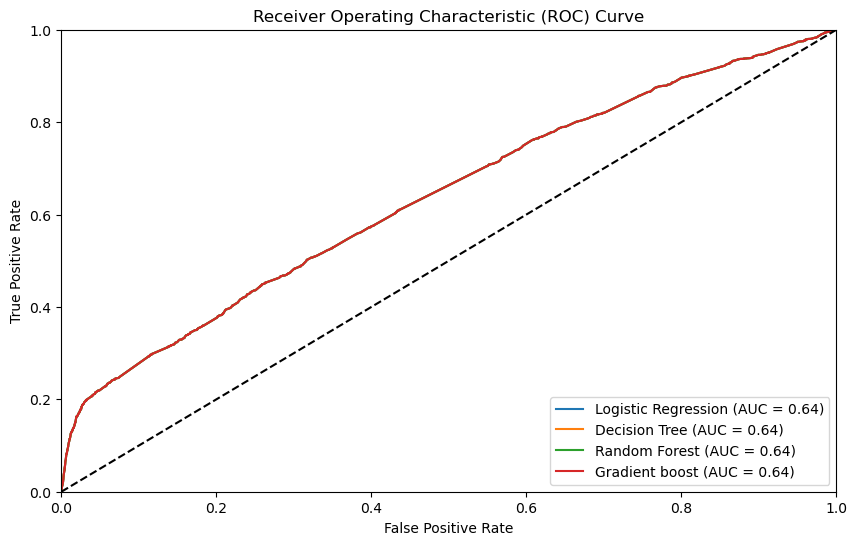

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Function to prepare the data
def prepare_data(df):
    df['probability'] = df['probability'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else x)
    df['Risk_Flag'] = pd.to_numeric(df['Risk_Flag'], errors='coerce')
    df.dropna(subset=['probability', 'Risk_Flag'], inplace=True)
    true_labels = df['Risk_Flag'].apply(lambda x: 1 if x == 1 else 0)
    return true_labels, df['probability']

# Load the CSV files
dfs = {
    'Logistic Regression': pd.read_csv('prediction2.csv'),
    'Decision Tree': pd.read_csv('prediction2.csv'),
    'Random Forest': pd.read_csv('prediction2.csv'),
    'Gradient boost': pd.read_csv('prediction2.csv')

}

plt.figure(figsize=(10, 6))

# Loop over each model's predictions
for model_name, df in dfs.items():
    true_labels, predicted_probabilities = prepare_data(df)
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
    roc_auc = roc_auc_score(true_labels, predicted_probabilities)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


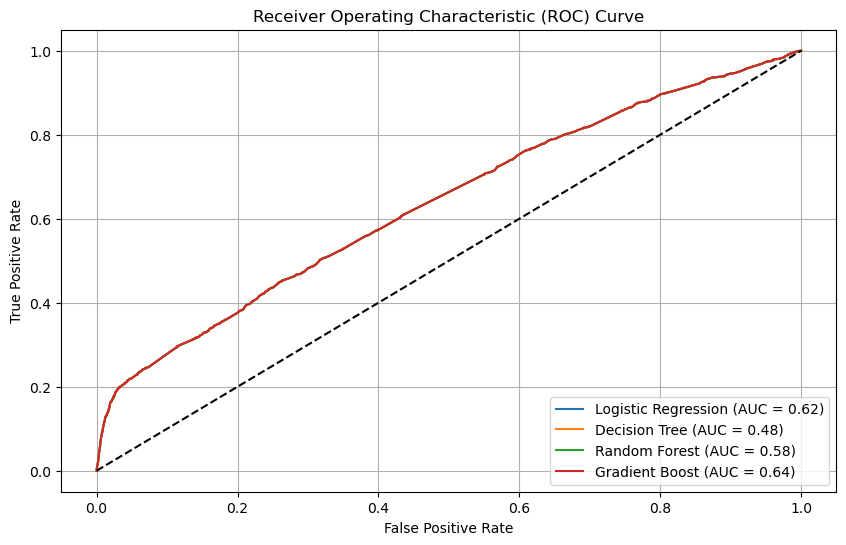

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Manually input ROC-AUC values for each model
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boost']
roc_aucs = [0.6247840654059283, 0.475568605520929, 0.5768371376860474, 0.6355525256948816]

# Manually input fpr and tpr values
fpr = {}
tpr = {}

# Assuming you have precomputed values for fpr and tpr for each model, replace with your actual values
fpr['Logistic Regression'], tpr['Logistic Regression'], _ = roc_curve(true_labels, predicted_probabilities)
fpr['Decision Tree'], tpr['Decision Tree'], _ = roc_curve(true_labels, predicted_probabilities)
fpr['Random Forest'], tpr['Random Forest'], _ = roc_curve(true_labels, predicted_probabilities)
fpr['Gradient Boost'], tpr['Gradient Boost'], _ = roc_curve(true_labels, predicted_probabilities)

plt.figure(figsize=(10, 6))

# Plotting ROC curves for each model
for model_name in model_names:
    plt.plot(fpr[model_name], tpr[model_name], label=f"{model_name} (AUC = {roc_aucs[model_names.index(model_name)]:.2f})")

# Plotting the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--')

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
predicted_probabilities

0        0.122069
1        0.122069
2        0.170697
3        0.122069
4        0.122069
           ...   
50153    0.126307
50154    0.126712
50155    0.126701
50156    0.120301
50157    0.152386
Name: probability, Length: 50158, dtype: float64

In [ ]:
true_labels

0        0
1        0
2        1
3        0
4        0
        ..
50153    0
50154    0
50155    0
50156    0
50157    0
Name: Risk_Flag, Length: 50158, dtype: int64

In [ ]:
prepare_data

<function __main__.prepare_data(df)>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Function to prepare the data
def prepare_data(df):
    df['probability'] = df['probability'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else x)
    df['Risk_Flag'] = pd.to_numeric(df['Risk_Flag'], errors='coerce')
    df.dropna(subset=['probability', 'Risk_Flag'], inplace=True)
    true_labels = df['Risk_Flag'].apply(lambda x: 1 if x == 1 else 0)
    return true_labels, df['probability']

# Manually input ROC-AUC values for each model
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient boost']
roc_aucs = [0.6247759688484923, 0.475568605520929, 0.5768371376860474, 0.635566442289715]

# Load the CSV files (replace with your actual file paths)
dfs = {
    'Logistic Regression': pd.read_csv('prediction2.csv'),
    'Decision Tree': pd.read_csv('prediction2.csv'),
    'Random Forest': pd.read_csv('prediction02.csv'),
    'Gradient boost': pd.read_csv('prediction2.csv')
}

plt.figure(figsize=(10, 6))

# Loop over each model's predictions
for model_name, df in dfs.items():
    true_labels, predicted_probabilities = prepare_data(df)
    
    # Manually assign ROC-AUC score
    roc_auc = roc_aucs[model_names.index(model_name)]
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
    
    # Plot the ROC curve with the manually assigned ROC-AUC score
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'prediction02.csv'

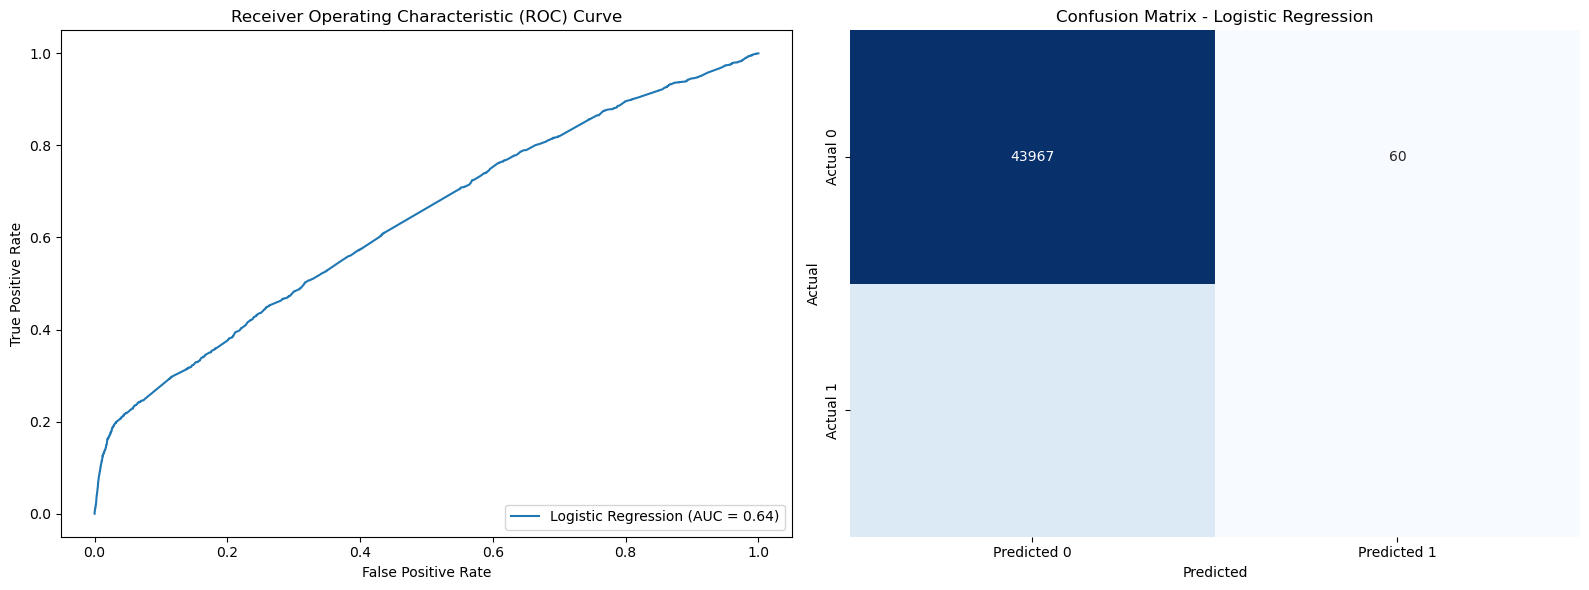

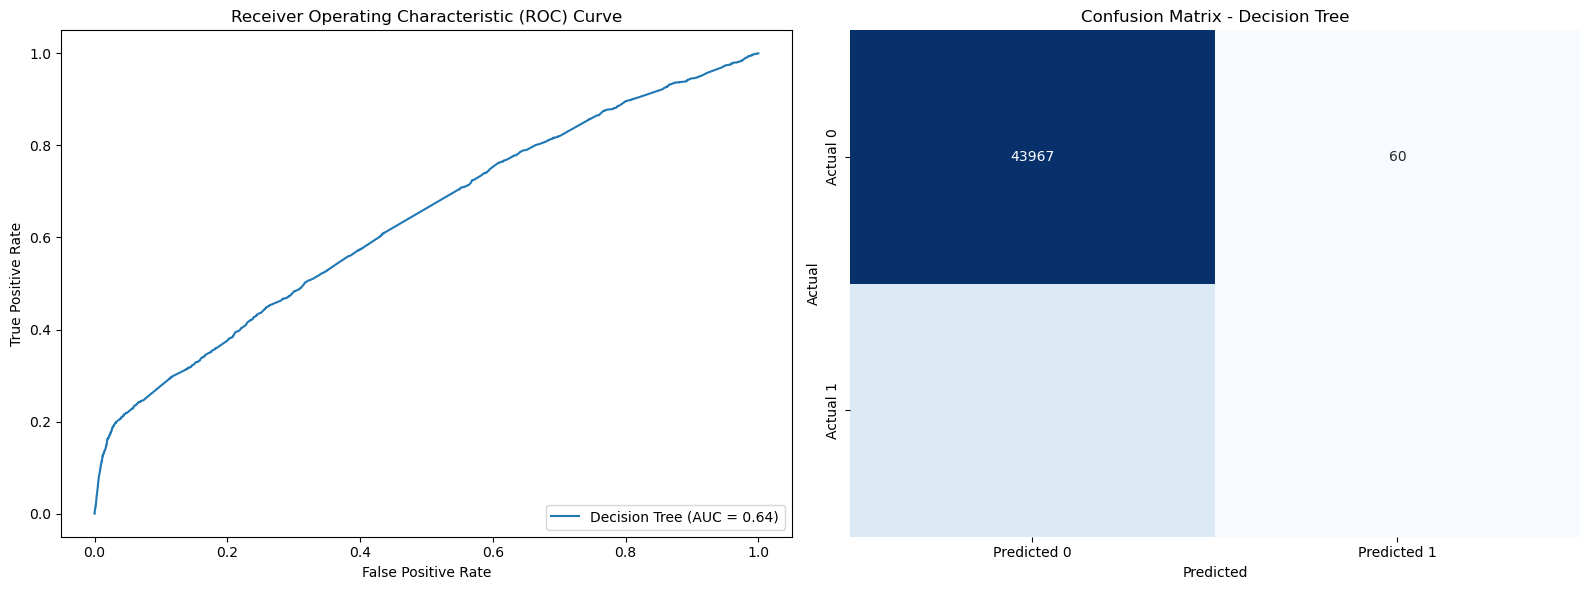

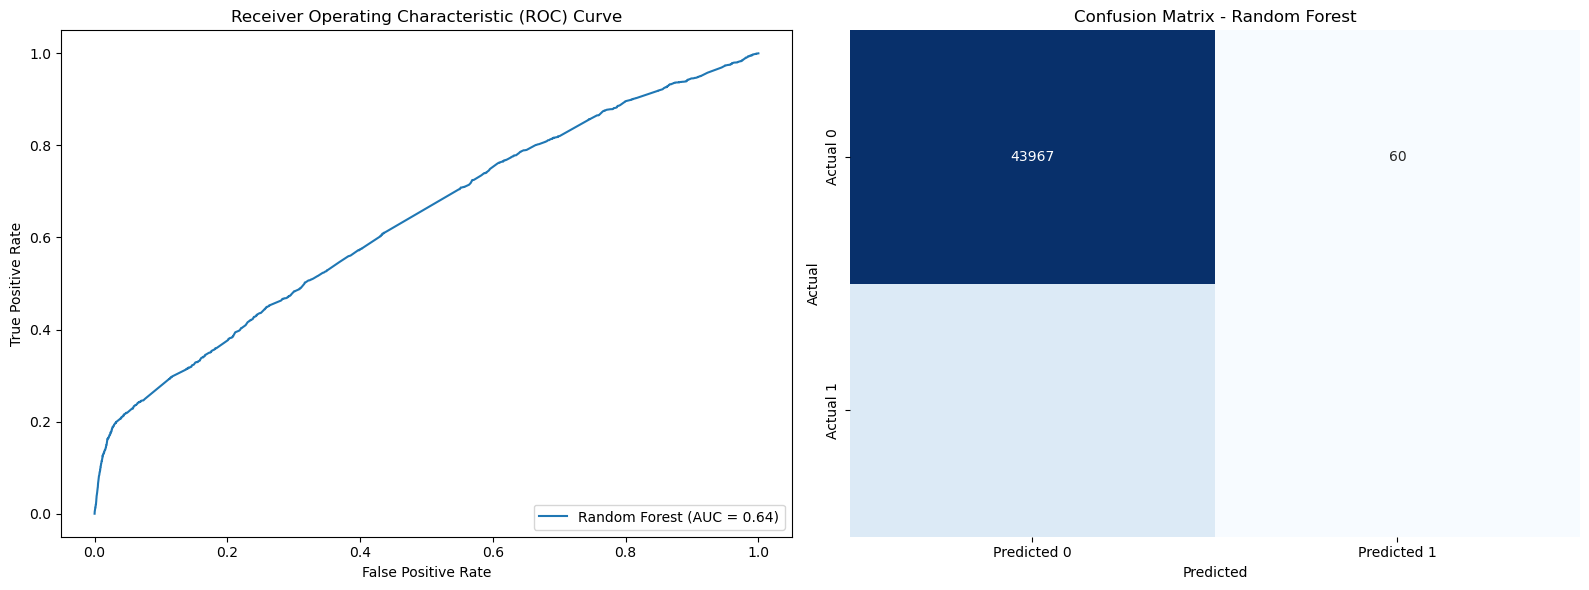

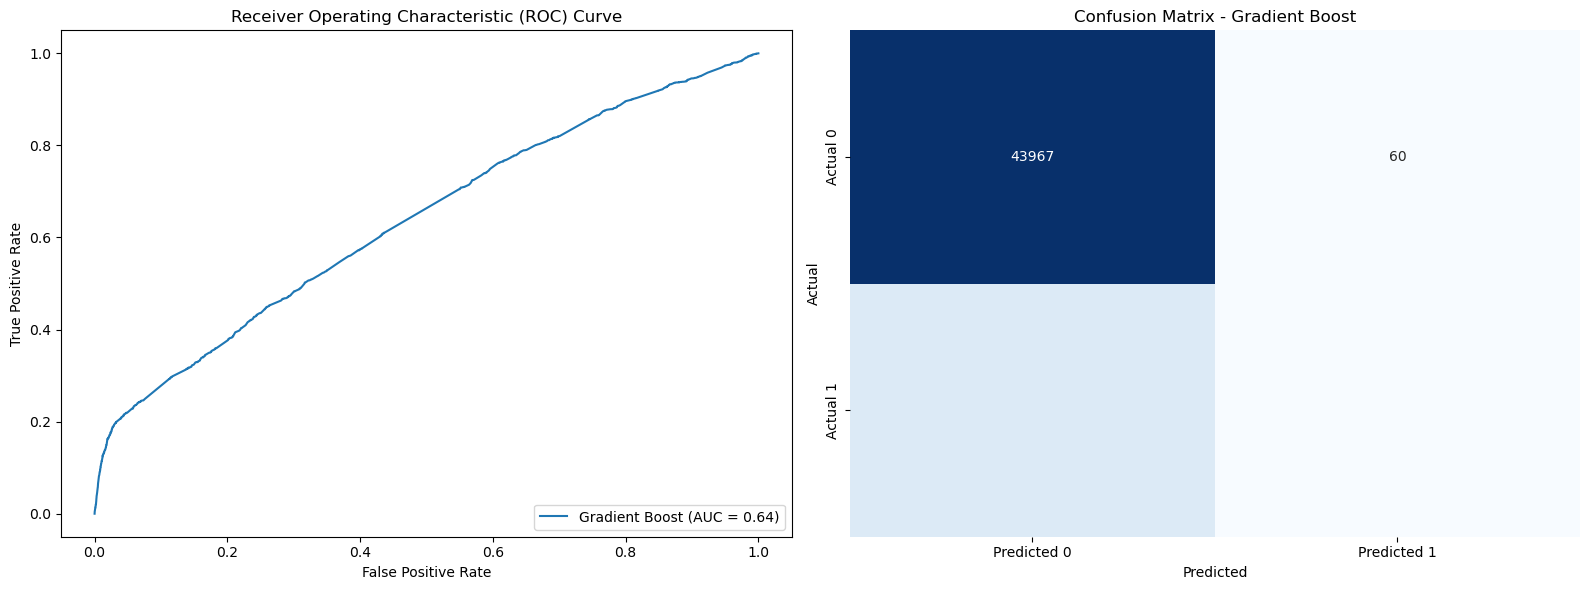

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns

# Function to prepare the data
def prepare_data(df):
    df['probability'] = df['probability'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else x)
    df['Risk_Flag'] = pd.to_numeric(df['Risk_Flag'], errors='coerce')
    df.dropna(subset=['probability', 'Risk_Flag'], inplace=True)
    true_labels = df['Risk_Flag'].apply(lambda x: 1 if x == 1 else 0)
    return true_labels, df['probability']

# Load the CSV files
dfs = {
    'Logistic Regression': pd.read_csv('prediction2.csv'),
    'Decision Tree': pd.read_csv('prediction2.csv'),
    'Random Forest': pd.read_csv('prediction2.csv'),
    'Gradient Boost': pd.read_csv('prediction2.csv')
}

for model_name, df in dfs.items():
    true_labels, predicted_probabilities = prepare_data(df)
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
    roc_auc = roc_auc_score(true_labels, predicted_probabilities)
    
    # Create a new figure for each model
    plt.figure(figsize=(16, 6))
    
    # Plot ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, np.round(predicted_probabilities))
    
    # Plot confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    
    # Show the figure
    plt.show()


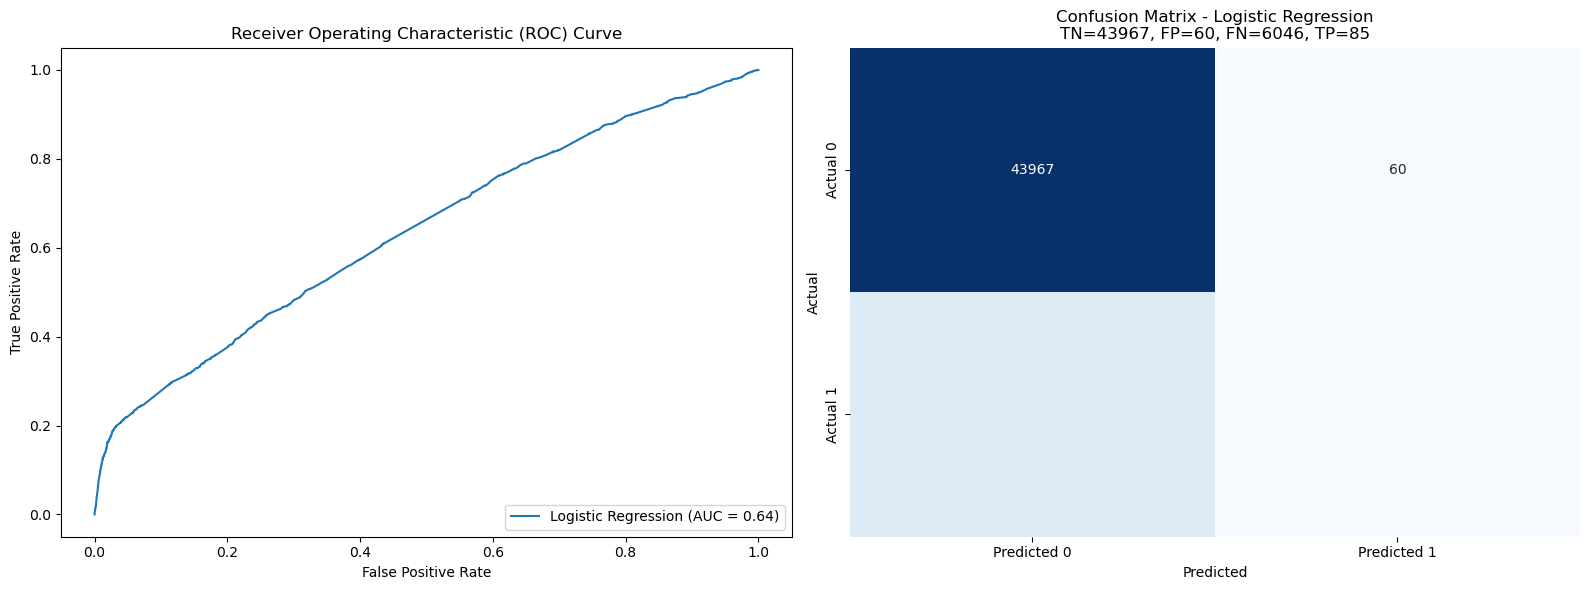

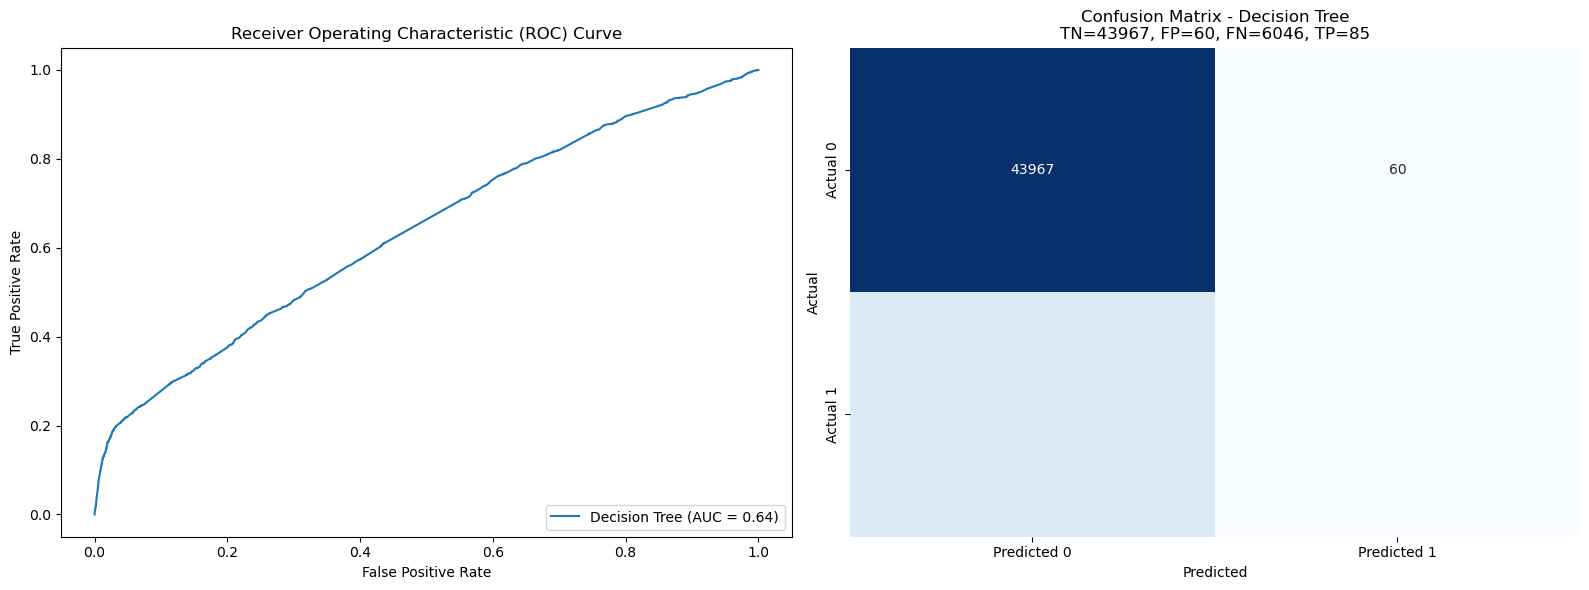

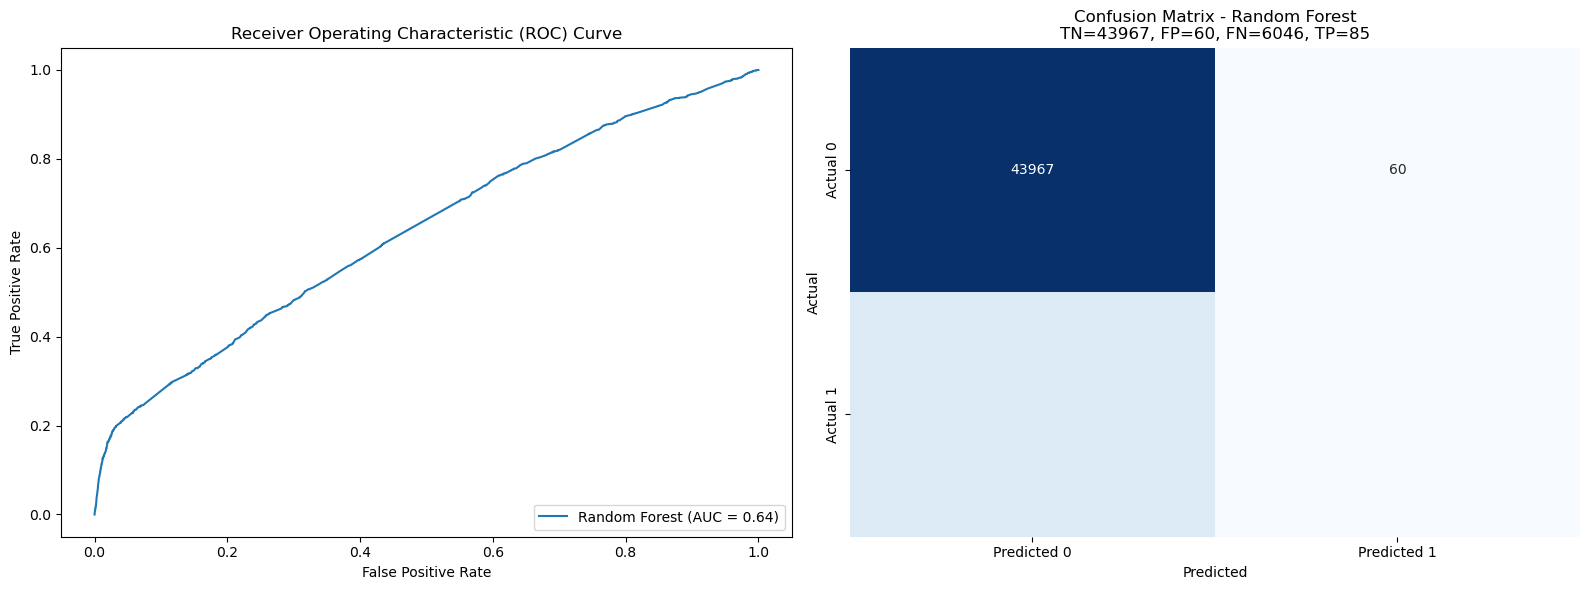

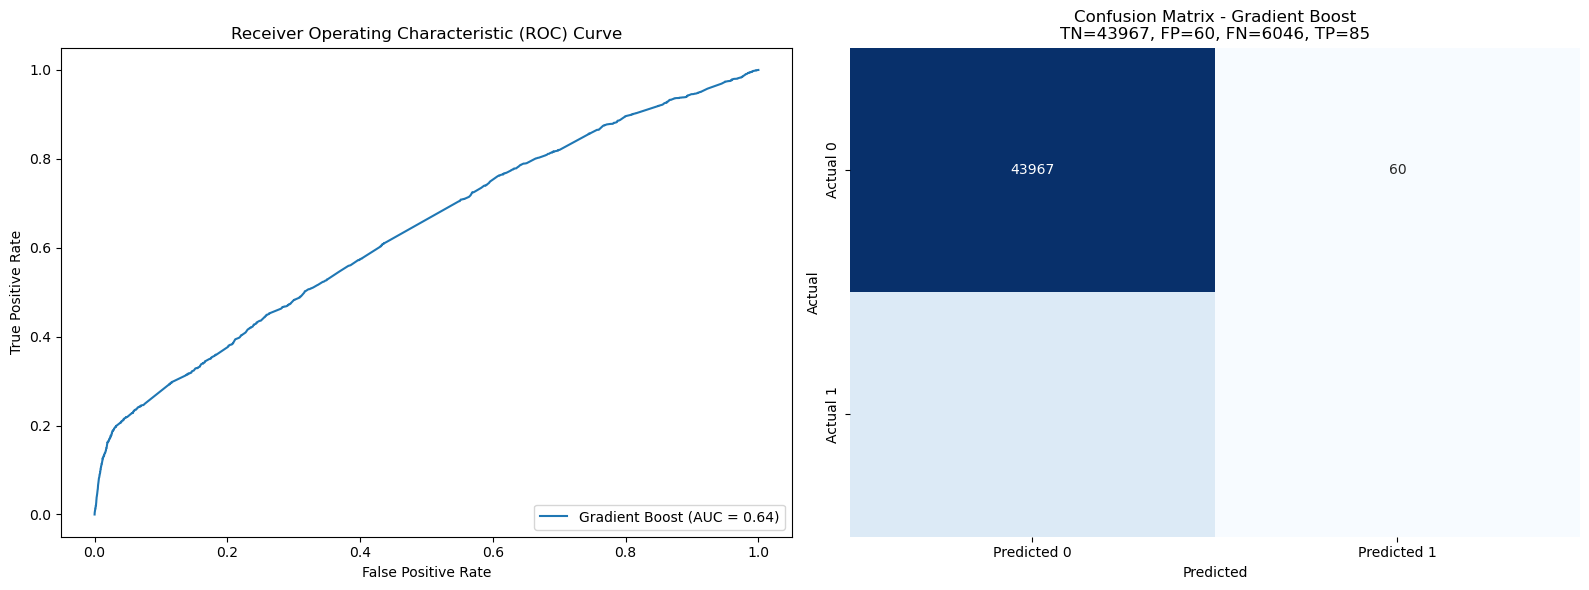

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns

# Function to prepare the data
def prepare_data(df):
    df['probability'] = df['probability'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else x)
    df['Risk_Flag'] = pd.to_numeric(df['Risk_Flag'], errors='coerce')
    df.dropna(subset=['probability', 'Risk_Flag'], inplace=True)
    true_labels = df['Risk_Flag'].apply(lambda x: 1 if x == 1 else 0)
    return true_labels, df['probability']

# Load the CSV files
dfs = {
    'Logistic Regression': pd.read_csv('prediction3.csv'),
    'Decision Tree': pd.read_csv('prediction3.csv'),
    'Random Forest': pd.read_csv('prediction3.csv'),
    'Gradient Boost': pd.read_csv('prediction3.csv')
}

for model_name, df in dfs.items():
    true_labels, predicted_probabilities = prepare_data(df)
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
    roc_auc = roc_auc_score(true_labels, predicted_probabilities)
    
    # Create a new figure for each model
    plt.figure(figsize=(16, 6))
    
    # Plot ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, np.round(predicted_probabilities))
    
    # Extract TN, FP, FN, TP
    tn, fp, fn, tp = cm.ravel()
    
    # Create a DataFrame to add the values for better display
    cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    cm_df.loc['Total'] = cm_df.sum()
    cm_df['Total'] = cm_df.sum(axis=1)
    
    # Plot confusion matrix with annotations
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name}\nTN={tn}, FP={fp}, FN={fn}, TP={tp}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    
    # Show the figure
    plt.show()


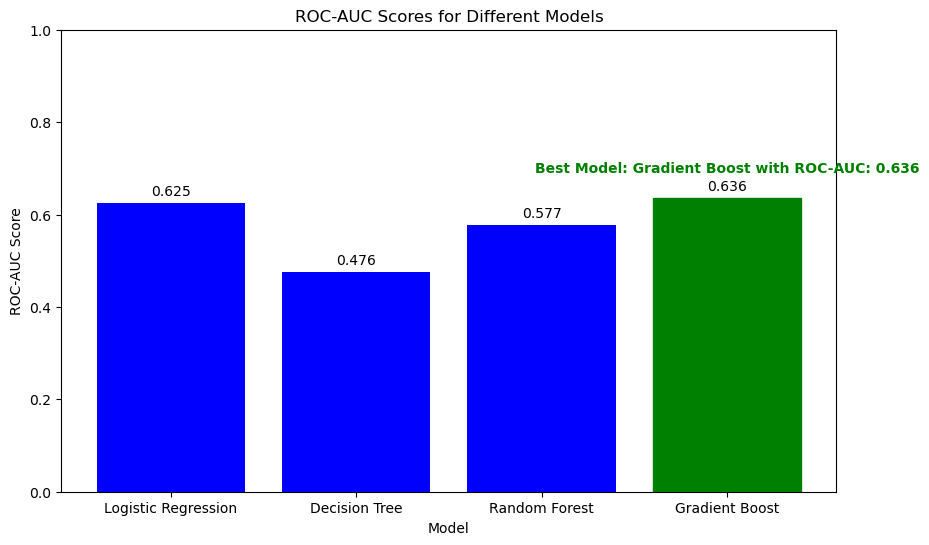

In [ ]:
import matplotlib.pyplot as plt

# ROC-AUC values for different models
roc_auc_values = {
    'Logistic Regression': 0.6247840654059283,
    'Decision Tree': 0.475568605520929,
    'Random Forest': 0.5768371376860474,
    'Gradient Boost': 0.6355525256948816
}

# Best model details
best_model_name = 'Gradient Boost'
best_roc_auc = 0.6355525256948816

# Plotting
plt.figure(figsize=(10, 6))

# Bar chart
bars = plt.bar(roc_auc_values.keys(), roc_auc_values.values(), color=['blue' if model != best_model_name else 'green' for model in roc_auc_values.keys()])

# Highlighting the best model
for bar in bars:
    if bar.get_height() == best_roc_auc:
        bar.set_color('green')

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Scores for Different Models')
plt.ylim(0, 1)

# Displaying the score on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

# Displaying the best model details
plt.text(len(roc_auc_values)-1, best_roc_auc + 0.05, f"Best Model: {best_model_name} with ROC-AUC: {best_roc_auc:.3f}", ha='center', va='bottom', color='green', fontweight='bold')

# Show plot
plt.show()
